In [1]:
import os
from posixpath import join
import paramiko
from scp import SCPClient
import subprocess

run_id = 22
jar_name = 'letter-frequency-1.0-SNAPSHOT.jar'
# connect with ssh


First analyze the letter frequencies in books across the eras. As performance is not relevant now, the job will be executed with 1 reducer, using combiner.
We hypotize that the input files are already in the input folder in hdfs, in /user/hadoop/letter_analysis/input/.

In [2]:
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect('10.1.1.124', username='hadoop', password='ubuntu')
root_dir = '/user/hadoop/historical_analysis'

# run the job for each file
for txt_file in os.listdir('../resources/historical_analysis/input'):
    print(f'Processing {txt_file}')
    input_dir = join(root_dir, 'input', txt_file)
    output_dir = join(root_dir, f'output_{run_id}', txt_file.split('.')[0])
    stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop jar {jar_name} it.unipi.cloud.MapReduceApp {input_dir} {output_dir}/count {output_dir}/freq 1 combiner')
    print(stderr.read().decode('utf-8'))
    print(stdout.read().decode('utf-8'))
    break

# copy the output to local
stdin, stdout, stderr = ssh.exec_command(f'/opt/hadoop/bin/hadoop fs -copyToLocal /user/hadoop/historical_analysis/output_{run_id} .')
print(stderr.read().decode('utf-8'))

if not os.path.exists(f'../resources/historical_analysis/output_{run_id}'):
    os.mkdir(f'../resources/historical_analysis/output_{run_id}')
    
scp = SCPClient(ssh.get_transport())
scp.get(f'output_{run_id}', '../resources/historical_analysis/', recursive=True)
scp.close()
ssh.close()

Processing 1294.txt
2024-06-18 10:25:49,200 INFO client.RMProxy: Connecting to ResourceManager at hadoop-namenode/10.1.1.124:8032
2024-06-18 10:25:49,767 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/hadoop/.staging/job_1716534983775_0180
2024-06-18 10:25:49,908 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-18 10:25:50,110 INFO input.FileInputFormat: Total input files to process : 1
2024-06-18 10:25:50,152 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-18 10:25:50,204 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = false
2024-06-18 10:25:50,224 INFO mapreduce.JobSubmitter: number of splits:1
2024-06-18 10:25:50,362 INFO sasl.SaslDataTransferClient: SASL encryption trust check: localHostTrusted = false, remoteHostTrusted = fals

After that we can analyze the output files.

../resources/historical_analysis/output_22
             a         b         c         d        e        f         g  \
1294  0.111057  0.006691  0.042903  0.043161  0.13091  0.00784  0.016282   

             h        i         j  ...         q         r         s  \
1294  0.014847  0.10383  0.000153  ...  0.010912  0.059874  0.052839   

             t        u       v         w         x         y         z  
1294  0.056696  0.03178  0.0188  0.000239  0.000153  0.000297  0.004528  

[1 rows x 26 columns]


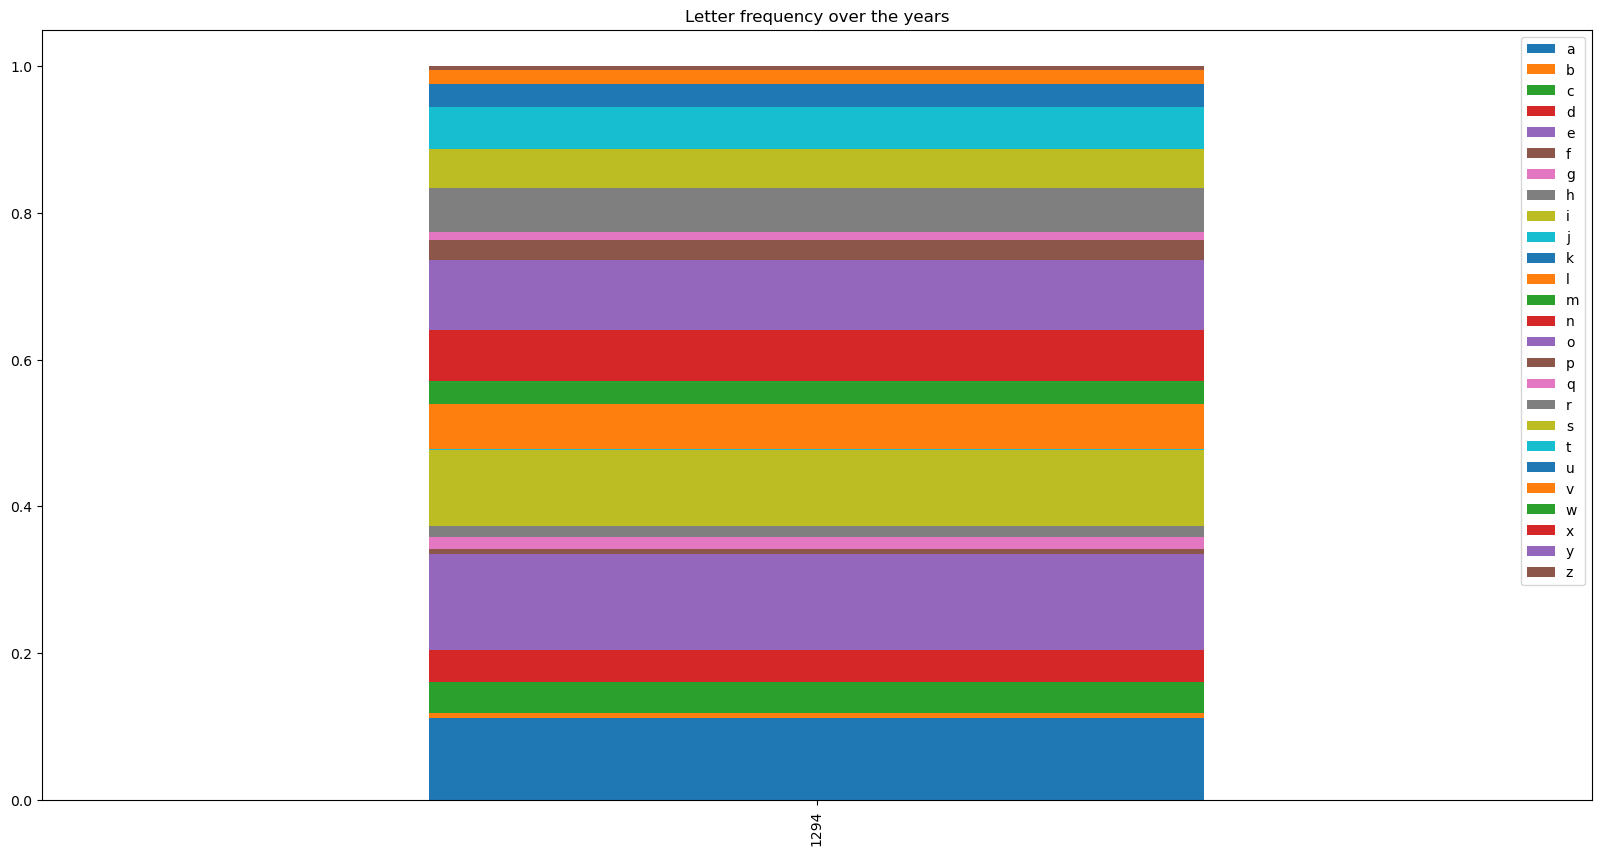

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

run_id = 22

directory = f'../resources/historical_analysis/output_{run_id}'
print(directory)

years = []
for filename in os.listdir(directory):
    year = filename.split('.')[0]
    years.append(year)

# col = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# df = pd.DataFrame(columns=col)

df = pd.DataFrame(index=years, columns=[])

for year in years:
    freq_per_year = []
    filepath = f'{directory}/{year}/freq/part-r-00000'
    with open(filepath, 'r') as f:
        for line in f:
            letter, freq = line.strip().split('\t')
            freq = float(freq)
            # if (letter in col):
                # df.loc[year, letter] = freq
            df.loc[year, letter] = freq
print(df)

df.plot( kind='bar', stacked=True, title='Letter frequency over the years', figsize=(20, 10))